In [1]:
# !python -m spacy download en_core_web_md

import requests
import spacy
from spacy.pipeline import merge_entities    
import itertools

nlp = spacy.load("en_core_web_md")
nlp.add_pipe("merge_entities") # IMPORTANT. This makes the entities into a single token. Otherwise you try to look up half an entity on Wiki, and that doesn't work.

# https://tl.wikipedia.org/wiki/Super_Bagyong_Odette
# sentence = "I'm scared of Typhoon Rai." 

# GPE:         Countries, cities, states.
# LOC:         Non-GPE locations, mountain ranges, bodies of water.
# EVENT:       Named hurricanes, battles, wars, sports events, etc.

# Goal: English sentences with Tagalog entities

def fetch_wikidata(params):
    url = 'https://www.wikidata.org/w/api.php'
    try:
        return requests.get(url, params=params)
    except:
        return 'There was an error'

def kb_translation_recursive(query, src='en', tgt='tl'):
    
    query = query.split()
    all_options = [' '.join(c) for c in reversed(sorted(itertools.chain(query[i:j] for i, j in itertools.combinations(range(len(query)+1), 2)), key=len))]
    return kb_recursion(all_options[0], all_options, 0, src, tgt)

def kb_translation(query, src='en', tgt='tl'):

    # Keep track if we remove the "the" or not, to put it back at the end if necessary
    changed = False
    
    # Preprocessing since the tokenizer thinks it is a good idea to include "the" in the NEs
    if query[0:4] == 'the ':
        query = query[4:]
        changed = True
        
    try:
            
        # Query
        params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'search': query,
                'language': src
            }
    
        # Query the knowledge base
        data = fetch_wikidata(params)
    
        # Get the ID corresponding to the query
        response = data.json()
    
        kb_id = response['search'][0]['id']
    
        # Knowledge base translation
        params = {
                'action': 'wbgetentities',
                'ids':kb_id, 
                'format': 'json',
                'languages': tgt
            }
    
        # fetch the API
        data = fetch_wikidata(params)
    
        # Show response
        data = data.json()

        if changed:
            return 'the ' + data['entities'][kb_id]['labels'][tgt]['value']
        else:
            return data['entities'][kb_id]['labels'][tgt]['value']

    except:
        print("No KB entry found for " + query)
        
        if changed:
            return 'the ' + query
        else:
            return query

def kb_recursion(query, all_options, i, src, tgt):

    try:
            
        # Query
        params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'search': query,
                'language': src
            }
    
        # Query the knowledge base
        data = fetch_wikidata(params)
    
        # Get the ID corresponding to the query
        response = data.json()
    
        kb_id = response['search'][0]['id']
    
        # Knowledge base translation
        params = {
                'action': 'wbgetentities',
                'ids':kb_id, 
                'format': 'json',
                'languages': tgt
            }
    
        # fetch the API
        data = fetch_wikidata(params)
    
        # Show response
        data = data.json()
        
        return data['entities'][kb_id]['labels'][tgt]['value']

    except:
        # Except will loop recursively through all the options, if no options are viable, the longest (original) value is returned
        
        try:
            return kb_recursion(all_options[i+1], all_options, i+1, src, tgt)
        except:
            return max(all_options) # The original will always be the longest entry in the list

def mask_sentence(sent, src='en', tgt='tl'):
    
    # Tokenize sentence
    doc = nlp(sent)
    
    # Get all the NE in that sentence, retrieve only the locations
    # Get the Tagalog versions of those NEs
    # Put the original sentence back together with the Tagalog locations
    
    masked_sent = ""
    general_masked_sent = ""
    src_translations = []
    tgt_translations = []
    sentence_count = 0
    kb_or_not = []
    
    for i,token in enumerate(doc):
        
        # NOTE: leaving the EVENTS out for now. Since we only want the locations.
        # if token.ent_type_ == "GPE" or token.ent_type_ == "LOC" or token.ent_type_ == "EVENT":
        
        if token.ent_type_ == "GPE" or token.ent_type_ == "LOC":
            kb_trans = kb_translation(token.text)

            if kb_trans != token.text:
                masked_sent += kb_trans
            else:
                masked_sent += "<MASK>"
            
            general_masked_sent += "<MASK>"
            
            # Keep some statistics
            src_translations.append(token.text)

            # This is going to mess up the statistics, but shouldn't matter for now
            if kb_trans != token.text:
                tgt_translations.append(kb_trans)
            else:
                tgt_translations.append("<MASK>")
            
            # DON'T count it if it's the same as the original, we care about a change in tokens
            if src_translations[-1] != tgt_translations[-1]:
                print(src_translations[-1], "->", tgt_translations[-1])
                sentence_count += len(token.text.split())
                kb_or_not.append(1)
            else:
                kb_or_not.append(0)
            
        else:
            masked_sent += token.text
            general_masked_sent += token.text
            
        masked_sent += token.whitespace_ # Only adds whitespace if it was originally there
        general_masked_sent += token.whitespace_

        if len(kb_or_not) > 0:
            kb_percentage = sum(kb_or_not) / len(kb_or_not)
        else:
            kb_percentage = 0
    
    return masked_sent, src_translations, tgt_translations, sentence_count, kb_percentage, general_masked_sent

# print("Original sentence:", sentence)
# print("Masked sentence:", mask_sentence(sentence)[0])

In [2]:
nlp_vanilla = spacy.load("en_core_web_md") # Unedited pipeline without merging

def mask_article(article):
    
    sentences = list(filter(None,article.split("\n"))) # Filter out the empty lists after splitting
    
    masked_article = ""
    general_masked_article = ""
    
    article_count = 0
    total_count = 0

    changed_article_percentage = 0

    all_kb_percentages = []
    
    for sent in sentences:

        masked_sent, src_translations, tgt_translations, sentence_count, kb_percentage, general_masked_sent = mask_sentence(sent)

        all_kb_percentages.append(kb_percentage)
        
        masked_article += masked_sent + "\n" # Add that newline back in the same way you did in the original
        general_masked_article += general_masked_sent + "\n"
        
        article_count += sentence_count # Only the masked words in that sentence
        
        total_count += len([token.text for token in nlp_vanilla(sent)])

    # Percentage of the words being masked/changed/augmented in a sentence
    article_percentage = article_count / total_count # Doing it this way for clarity

    # Percentage of the words we look up actually having a KB entry
    if len(all_kb_percentages) > 0:
        kb_article_percentage = sum(all_kb_percentages) / len(all_kb_percentages)
    else:
        kb_article_percentage = 0
    
    return masked_article, article_count, article_percentage, kb_article_percentage, general_masked_article

In [3]:
%%time

import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
pd.set_option('mode.chained_assignment', None)

file_name = "./custom data/finetuning/Finetuning flooding data 15-01-24 complete"

excel = pd.read_excel(file_name + " masked 22-03-24.xlsx")

# RUN THIS ONLY ONCE TO INITIALIZE ------------------------------
# excel["Masked"] = [np.nan for x in excel["English"]] # Init
# excel["Masked count"] = [np.nan for x in excel["English"]] # Init
# excel["Masked percentage"] = [np.nan for x in excel["English"]] # Init
# excel["KB available percentage"] = [np.nan for x in excel["English"]] # Init
# excel["General mask"] = [np.nan for x in excel["English"]] # Init
# excel.to_excel(file_name + " masked 22-03-24.xlsx", index=False)
# ---------------------------------------------------------------

data_copy = excel.copy()

data_copy["Masked"] = ["" for x in data_copy["English"]] # Init
data_copy["Masked count"] = [0 for x in data_copy["English"]] # Init
data_copy["Masked percentage"] = [0 for x in data_copy["English"]] # Init
data_copy["KB available percentage"] = [0 for x in data_copy["English"]] # Init
data_copy["General mask"] = ["" for x in data_copy["English"]] # Init

total_masked = []
total_masked_count = []
total_masked_pencentage = []
total_kb_availability = []
total_masked_general = []

for i, article in tqdm(enumerate(data_copy["English"]), total=len(data_copy["English"])):

    # Check if result already exists
    if type(excel["Masked"][i]) is str:
        total_masked.append(excel["Masked"][i])
        data_copy["Masked"][i] = total_masked[i]

        total_masked_count.append(excel["Masked count"][i])
        data_copy["Masked count"][i] = total_masked_count[i]

        total_masked_pencentage.append(excel["Masked percentage"][i])
        data_copy["Masked percentage"][i] = total_masked_pencentage[i]

        total_kb_availability.append(excel["KB available percentage"][i])
        data_copy["KB available percentage"][i] = total_kb_availability[i]

        total_masked_general.append(excel["General mask"][i])
        data_copy["General mask"][i] = total_masked_general[i]
    
        data_copy.to_excel(file_name + " masked 22-03-24.xlsx", index=False)
        continue

    masked_article, article_count, article_percentage, kb_article_percentage, general_masked_article = mask_article(article)
    
    total_masked.append(masked_article)
    total_masked_count.append(article_count)
    total_masked_pencentage.append(article_percentage)
    total_kb_availability.append(kb_article_percentage)
    total_masked_general.append(general_masked_article)
    
    data_copy["Masked"][i] = total_masked[i]
    data_copy["Masked count"][i] = total_masked_count[i]  
    data_copy["Masked percentage"][i] = total_masked_pencentage[i]
    data_copy["KB available percentage"][i] = total_kb_availability[i]
    data_copy["General mask"][i] = total_masked_general[i]
    
    data_copy.to_excel(file_name + " masked 22-03-24.xlsx", index=False)

data_copy["Masked"] = total_masked
data_copy["Masked count"] = total_masked_count
data_copy["Masked percentage"] = total_masked_pencentage
data_copy["KB available percentage"] = total_kb_availability
data_copy["General mask"] = total_masked_general

data_copy.to_excel(file_name + " masked complete 22-03-24.xlsx", index=False)
    
print("Total count:", sum(total_masked_count))
print("Percentage masked over all articles:", sum(total_masked_pencentage)/len(total_masked_pencentage))
print("Percentage of KB entries available:", sum(total_kb_availability)/len(total_kb_availability))

  0%|          | 0/816 [00:00<?, ?it/s]

New York -> Lungsod ng New York
New York -> Lungsod ng New York
New York -> Lungsod ng New York
New York City -> Lungsod ng New York
Niagara Falls -> <MASK>
No KB entry found for Lake George
Lake George -> <MASK>
New York -> Lungsod ng New York
No KB entry found for Hudson Valley
Hudson Valley -> <MASK>
New York -> Lungsod ng New York
New York -> Lungsod ng New York
New York -> Lungsod ng New York
New York -> Lungsod ng New York
No KB entry found for Western Cape
Western Cape -> <MASK>
No KB entry found for North-West
North-West -> <MASK>
UK -> United Kingdom
UK -> United Kingdom
Scotland -> Eskosya
Scotland -> Eskosya
No KB entry found for Central Florida
Central Florida -> <MASK>
Orlando -> <MASK>
New Zealand -> <MASK>
Bangladesh -> <MASK>
No KB entry found for Mount Maunganui
Mount Maunganui -> <MASK>
No KB entry found for New Zealand's
New Zealand's -> <MASK>
No KB entry found for Black Caps
the Black Caps -> <MASK>
Bangladesh -> <MASK>
New Zealand -> <MASK>
Bangladesh -> <MASK>
No

In [ ]:
# Total count: 2191
# Percentage masked over all articles: 0.006959837806812766
# Percentage of KB entries available: 0.08284344962655128
# These are the stats if we DON'T always put a general mask over the entities without a KB entry

# This means that in total 0.7% of the article gets masked
# But more interestingly, only 8% of the entities that we look up have a KB entry.

The number of change over 7.5%: 73
The number of change under 1.0%: 176


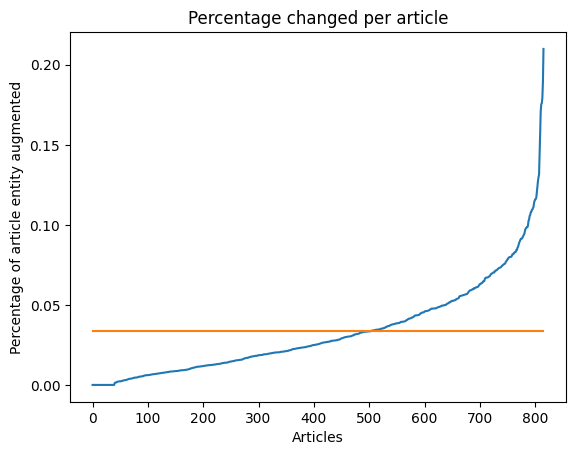

In [4]:
# Get the average percentage, see how many fall outside of a standard deviation of that

import matplotlib.pyplot as plt
import pandas as pd

# file_name = "./custom data/finetuning/Finetuning flooding data 15-01-24 complete"

excel_complete = pd.read_excel(file_name + " masked complete 22-03-24.xlsx")
data_masked = excel_complete.copy() # do NOT touch the original data with your filthy paws

average = sum(data_masked["Masked percentage"])/len(data_masked["Masked percentage"])

plt.plot(range(len(data_masked["Masked percentage"])), sorted(data_masked["Masked percentage"]))
plt.plot(range(len(data_masked["Masked percentage"])), [average for x in range(len(data_masked["Masked percentage"]))])
plt.title("Percentage changed per article")
plt.xlabel("Articles")
plt.ylabel("Percentage of article entity augmented")

higher_percentage = 0.075
lower_percentage = 0.01

print("The number of change over " + str(higher_percentage*100) + "%:", len([x for x in data_masked["Masked percentage"] if x > higher_percentage]))
print("The number of change under " + str(lower_percentage*100) + "%:", len([x for x in data_masked["Masked percentage"] if x < lower_percentage]))

# That 1% seems like a good boundary

In [5]:
# From that other file
# from pybacktrans import BackTranslator
import httpcore
setattr(httpcore, 'SyncHTTPTransport', any)
from googletrans import Translator
from tqdm.notebook import tqdm
from time import sleep

translator = Translator()

def translate(word):
    result = None

    if word == "" or word == " " or word == "\n":
        return word
    
    while result == None: 
        try:
            result = translator.translate(word, dest="tl", src="en").text
        except:
            print(word)
            print(result)
            print("Trying translation again!")

    return result

In [6]:
import math
from string import punctuation
import nltk
from nltk.corpus import stopwords
import random
 
# nltk.download('stopwords')

masked_fixed = []
general_mask_fixed = []

# For all the articles we masked
for article in tqdm(data_masked.iterrows(), total=len(data_masked)):
    
    # Check if the percentage is below the 1%
    if article[1]["Masked percentage"] < 0.01:

        tokens = nlp(article[1]["English"])
        
        # If they are, count the length of the tokenized article, calculate what 1% of that is
        tokens_replaced_n = math.ceil(len(tokens)/100)

        indices_sample = random.sample(range(len(tokens)), tokens_replaced_n)
        indices_filtered = indices_sample.copy()

        # Make sure the sample contains proper words (mostly)
        for i, index_sampled in enumerate(indices_sample):
            index = index_sampled
            
            while any(c in punctuation for c in tokens[index].text) or tokens[index].text.isdigit() or tokens[index].text in stopwords.words('english') or tokens[index].text == "\n":
                index = random.choice([i for i in range(len(tokens)) if i not in indices_filtered]) # This already takes care of not generating duplicates

            # Uncomment to see what tokens are being corrected
            #     print("AGAIN")
            #     print(tokens[i])
            #     print(tokens[index])
            # print("DONE")
            # print()
            
            indices_filtered[i] = index
            
            assert len(set(indices_filtered)) == len(indices_filtered) # Assert that we are not adding any duplicates

        # For those words, translate them before putting them back
        masked_article = ""
        general_masked_article = ""
        
        for i, token in enumerate(tokens):
            if i in indices_filtered: # The tokens we want to translate
                # masked_article += translate(token.text)
                masked_article += "<MASK>"
                general_masked_article += "<MASK>"
            else:
                masked_article += token.text
                general_masked_article += token.text
            masked_article += token.whitespace_
            general_masked_article += token.whitespace_

        masked_fixed.append(masked_article)
        general_mask_fixed.append(general_masked_article)
    
    # Else just copy the article from the masked column
    else:
        masked_fixed.append(article[1]["Masked"])
        general_mask_fixed.append(article[1]["General mask"])
        
data_masked["Masked fixed"] = masked_fixed
data_masked["General mask fixed"] = general_mask_fixed

  0%|          | 0/816 [00:00<?, ?it/s]

In [7]:
data_masked.to_excel(file_name + " masked complete fixed 22-03-24.xlsx", index=False)

In [8]:
from sklearn.model_selection import train_test_split

masked, parallel = train_test_split(data_masked, test_size=0.1)

name = "Finetuning flooding data"

# Larger 0.9 masked set
np.savetxt(name + " MODEL4 EN.txt", masked["English"].values, fmt="%s")
np.savetxt(name + " MODEL4 EN masked.txt", masked["Masked fixed"].values, fmt="%s")

# Smaller 0.1 parallel set
np.savetxt(name + " MODEL5 EN.txt", parallel["English"].values, fmt="%s")
np.savetxt(name + " MODEL5 TL.txt", parallel["Tagalog"].values, fmt="%s")

# Masked set ONLY
np.savetxt(name + " MODEL6 EN.txt", masked["English"].values, fmt="%s")
np.savetxt(name + " MODEL6 EN masked.txt", masked["General mask fixed"].values, fmt="%s")